# ECRQ Tables and Graphs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.iolib.summary2 import summary_col

In [5]:
# Load the data
dtype_dict = {
    'white_adj_supply_any_avg_tract': np.float32,
    'white_adj_supply_hr_avg_tract': np.float32,
    'white_totcost_any_avg_tract': np.float32,
    'black_adj_supply_any_avg_tract': np.float32,
    'black_adj_supply_hr_avg_tract': np.float32,
    'black_totcost_any_avg_tract': np.float32,
    'am_indian_alaska_native_adj_supply_any_avg_tract': np.float32,
    'am_indian_alaska_native_adj_supply_hr_avg_tract': np.float32,
    'am_indian_alaska_native_totcost_any_avg_tract': np.float32,
    'asian_supply_adj_supply_any_tract': np.float32,
    'asian_adj_supply_hr_avg_tract': np.float32,
    'asian_totcost_any_avg_tract': np.float32,
    'native_hawaiian_pacific_islander_adj_supply_any_avg_tract': np.float32,
    'native_hawaiian_pacific_islander_adj_supply_hr_avg_tract': np.float32,
    'native_hawaiian_pacific_islander_totcost_any_avg_tract': np.float32,
    'other_race_adj_supply_any_avg_tract': np.float32,
    'other_race_adj_supply_hr_avg_tract': np.float32,
    'other_race_totcost_any_avg_tract': np.float32,
    'two_or_more_races_adj_supply_any_avg_tract': np.float32,
    'two_or_more_races_adj_supply_hr_avg_tract': np.float32,
    'two_or_more_races_totcost_any_avg_tract': np.float32,
    'hispanic_latino_adj_supply_any_avg_tract': np.float32,
    'hispanic_latino_adj_supply_hr_avg_tract': np.float32,
    'hispanic_latino_totcost_any_avg_tract': np.float32,
    'state': np.int32,
    'county': np.int32,
    'tract': np.int32,
    'median_household_income': np.float32,
    'gini_index': np.float32,
    'educational_attainment': np.float32,
    'employment_status': np.float32,
    'housing_tenure': np.float32,
    'poverty_status': np.float32,
    'commute_time': np.float32,
    'without_health_insurance': np.float32,
    'labor_force_status': np.float32,
    'total_population_25_years_and_over': np.float32,
    'white': np.float32,
    'black': np.float32,
    'am_indian_alaska_native': np.float32,
    'asian': np.float32,
    'native_hawaiian_pacific_islander': np.float32,
    'other_race': np.float32,
    'two_or_more_races': np.float32,
    'hispanic_latino': np.float32,
    'total_tract_population': np.int32
}


data = pd.read_csv('../data/acs_data.csv', dtype=dtype_dict)  # Replace with the path to your data file

# Rename the variables
data.rename(columns={
    'white_adj_supply_any_avg_tract': 'White any',
    'white_adj_supply_hr_avg_tract': 'White high rated',
    'white_totcost_any_avg_tract': 'White total cost',
    'black_adj_supply_any_avg_tract': 'Black any',
    'black_adj_supply_hr_avg_tract': 'Black high rated',
    'black_totcost_any_avg_tract': 'Black total cost',
    'am_indian_alaska_native_adj_supply_any_avg_tract': 'American Indian Alaska Native any',
    'am_indian_alaska_native_adj_supply_hr_avg_tract': 'American Indian Alaska Native high rated',
    'am_indian_alaska_native_totcost_any_avg_tract': 'American Indian Alaska Native total cost',
    'asian_adj_supply_any_avg_tract': 'Asian any',
    'asian_adj_supply_hr_avg_tract': 'Asian high rated',
    'asian_totcost_any_avg_tract': 'Asian total cost',
    'native_hawaiian_pacific_islander_adj_supply_any_avg_tract': 'Native Hawaiian Pacific Islander any',
    'native_hawaiian_pacific_islander_adj_supply_hr_avg_tract': 'Native Hawaiian Pacific Islander high rated',
    'native_hawaiian_pacific_islander_totcost_any_avg_tract': 'Native Hawaiian Pacific Islander total cost',
    'other_race_adj_supply_any_avg_tract': 'Other race any',
    'other_race_adj_supply_hr_avg_tract': 'Other race high rated',
    'other_race_totcost_any_avg_tract': 'Other race total cost',
    'two_or_more_races_adj_supply_any_avg_tract': 'Two or more races any',
    'two_or_more_races_adj_supply_hr_avg_tract': 'Two or more races high rated',
    'two_or_more_races_totcost_any_avg_tract': 'Two or more races total cost',
    'hispanic_latino_adj_supply_any_avg_tract': 'Hispanic Latino any',
    'hispanic_latino_adj_supply_hr_avg_tract': 'Hispanic Latino high rated',
    'hispanic_latino_totcost_any_avg_tract': 'Hispanic Latino total cost',
    'median_household_income': 'Median Household Income',
    'gini_index': 'Gini Index',
    'educational_attainment': 'Educational Attainment',
    'employment_status': 'Employment Status',
    'housing_tenure': 'Housing Tenure',
    'poverty_status': 'Poverty Status',
    'commute_time': 'Commute Time',
    'without_health_insurance': 'Without Health Insurance',
    'labor_force_status': 'Labor Force Status',
    'total_population_25_years_and_over': 'Total Population 25 Years and Over'
}, inplace=True)

# calculate state population
state_population = data.groupby('state')['total_tract_population'].transform('sum')

# create tract_weight
data['tract_weight'] = data['total_tract_population'] / state_population

In [6]:
data.head()

,White any,White high rated,White total cost,Black any,Black high rated,Black total cost,American Indian Alaska Native any,American Indian Alaska Native high rated,American Indian Alaska Native total cost,Asian any,...,white,black,am_indian_alaska_native,asian,native_hawaiian_pacific_islander,other_race,two_or_more_races,hispanic_latino,total_tract_population,tract_weight
0,0.027303,0.007869,141.404892,0.040353,0.011630,145.017502,0.000002,5.932382e-14,135.126480,6.304092e-07,...,0.000458,0.000042,0.000741,0.000063,0.000000,0.000308,0.000133,0.000150,2240,0.000404
1,0.229566,0.000000,48.881134,0.668083,0.000000,39.188812,0.097253,0.000000e+00,82.443626,6.680830e-01,...,0.000446,0.000020,0.001586,0.000004,0.001367,0.000048,0.000732,0.000067,2284,0.000411
2,0.463983,0.078133,147.899124,0.341689,0.050960,150.966522,0.301611,3.909673e-02,151.896408,4.202191e-01,...,0.000719,0.000079,0.000672,0.000048,0.000000,0.000019,0.000514,0.000240,3483,0.000627
3,0.413980,0.027758,71.953590,0.568615,0.042709,52.525444,0.921216,7.764238e-02,57.557652,0.000000e+00,...,0.000593,0.000070,0.002534,0.000000,0.000000,0.000019,0.000375,0.000134,2970,0.000535
4,0.012008,0.000000,72.200478,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000406,0.000011,0.000000,0.000052,0.000000,0.000000,0.000085,0.000033,1905,0.000343


## Summary Statistics

In [7]:
variables = {
    'White any': 'white',
    'White high rated': 'white',
    'White total cost': 'white',
    'Black any': 'black',
    'Black high rated': 'black',
    'Black total cost': 'black',
    'American Indian Alaska Native any': 'am_indian_alaska_native',
    'American Indian Alaska Native high rated': 'am_indian_alaska_native',
    'American Indian Alaska Native total cost': 'am_indian_alaska_native',
    'Asian any': 'asian',
    'Asian high rated': 'asian',
    'Asian total cost': 'asian',
    'Native Hawaiian Pacific Islander any': 'native_hawaiian_pacific_islander',
    'Native Hawaiian Pacific Islander high rated': 'native_hawaiian_pacific_islander',
    'Native Hawaiian Pacific Islander total cost': 'native_hawaiian_pacific_islander',
    'Other race any': 'other_race',
    'Other race high rated': 'other_race',
    'Other race total cost': 'other_race',
    'Two or more races any': 'two_or_more_races',
    'Two or more races high rated': 'two_or_more_races',
    'Two or more races total cost': 'two_or_more_races',
    'Hispanic Latino any': 'hispanic_latino',
    'Hispanic Latino high rated': 'hispanic_latino',
    'Hispanic Latino total cost': 'hispanic_latino',
    'Median Household Income': 'median_household_income',
    'Gini Index': 'gini_index',
    'Educational Attainment': 'educational_attainment',
    'Employment Status': 'employment_status',
    'Housing Tenure': 'housing_tenure',
    'Poverty Status': 'poverty_status',
    'Commute Time': 'commute_time',
    'Without Health Insurance': 'without_health_insurance',
    'Labor Force Status': 'labor_force_status',
    'Total Population 25 Years and Over': 'total_population_25_years_and_over'
}

racial_groups = list(variables.keys())[:24]
racial_weights = list(variables.values())[:24]
other_covariates = list(variables.keys())[24:]

summary_statistics = {}

# Calculate weighted averages and standard deviations for racial groups
for group, weight in zip(racial_groups, racial_weights):
    weighted_mean = (data[group] * data[weight]).sum()
    weighted_std = np.sqrt((data[weight] * (data[group] - weighted_mean)**2).sum())
    summary_statistics[group] = {'mean': weighted_mean, 'std': weighted_std}

# Calculate weighted averages and standard deviations for other covariates using 'tract_weight' as weight
for covariate in other_covariates:
    weighted_mean = (data[covariate] * data['tract_weight']).sum() / data['tract_weight'].sum()
    weighted_std = np.sqrt((data['tract_weight'] * (data[covariate] - weighted_mean)**2).sum() / data['tract_weight'].sum())
    summary_statistics[covariate] = {'mean': weighted_mean, 'std': weighted_std}

# Convert the dictionary to a DataFrame
summary_statistics_df = pd.DataFrame(summary_statistics).T

# Format the summary statistics table
summary_statistics_df = summary_statistics_df.applymap('{:.2f}'.format)
summary_statistics_df['std'] = '(' + summary_statistics_df['std'] + ')'
summary_statistics_df.rename(columns={'mean': 'Mean', 'std': 'Std Deviation'}, inplace=True)

print(summary_statistics_df)


                                                 Mean Std Deviation
White any                                        0.57        (0.28)
White high rated                                 0.13        (0.12)
White total cost                               179.35       (67.40)
Black any                                        0.59        (0.24)
Black high rated                                 0.20        (0.11)
Black total cost                               214.47       (52.29)
American Indian Alaska Native any                0.59        (0.37)
American Indian Alaska Native high rated         0.12        (0.14)
American Indian Alaska Native total cost       135.05       (74.13)
Asian any                                        0.54        (0.24)
Asian high rated                                 0.18        (0.10)
Asian total cost                               215.61       (59.33)
Native Hawaiian Pacific Islander any             0.55        (0.34)
Native Hawaiian Pacific Islander high rated     

## CDF Plots

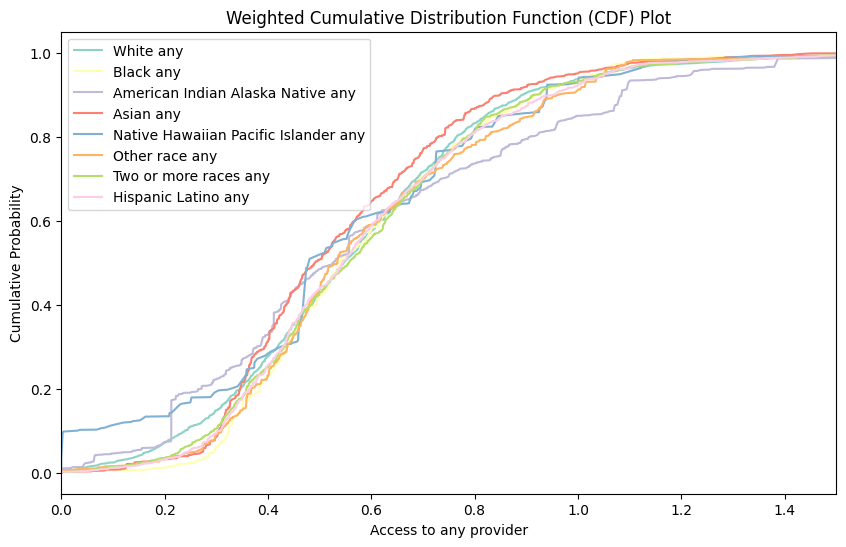

In [22]:
# CDF plot
race_variables1 = [
    'White any', 
    'Black any', 
    'American Indian Alaska Native any', 
    'Asian any', 
    'Native Hawaiian Pacific Islander any',
    'Other race any', 
    'Two or more races any', 
    'Hispanic Latino any',
]

colors = [
    '#8dd3c7', 
    '#ffffb3', 
    '#bebada', 
    '#fb8072', 
    '#80b1d3', 
    '#fdb462', 
    '#b3de69', 
    '#fccde5']

weight_map1 = {
    'White any': 'white',
    'Black any': 'black',
    'American Indian Alaska Native any': 'am_indian_alaska_native',
    'Asian any': 'asian',
    'Native Hawaiian Pacific Islander any': 'native_hawaiian_pacific_islander',
    'Other race any': 'other_race',
    'Two or more races any': 'two_or_more_races',
    'Hispanic Latino any': 'hispanic_latino',
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables1, colors):
    # Get the weights for this variable
    weights = data[weight_map1[var]]
    
    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))
    
    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)
    
    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]
    
    ax.plot(values, cumulative, label=var, color=color)

ax.set_title('Weighted Cumulative Distribution Function (CDF) Plot')
ax.set_xlabel('Access to any provider')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='upper left')

# Set x-axis limit
ax.set_xlim(0, 1.5)

plt.show()

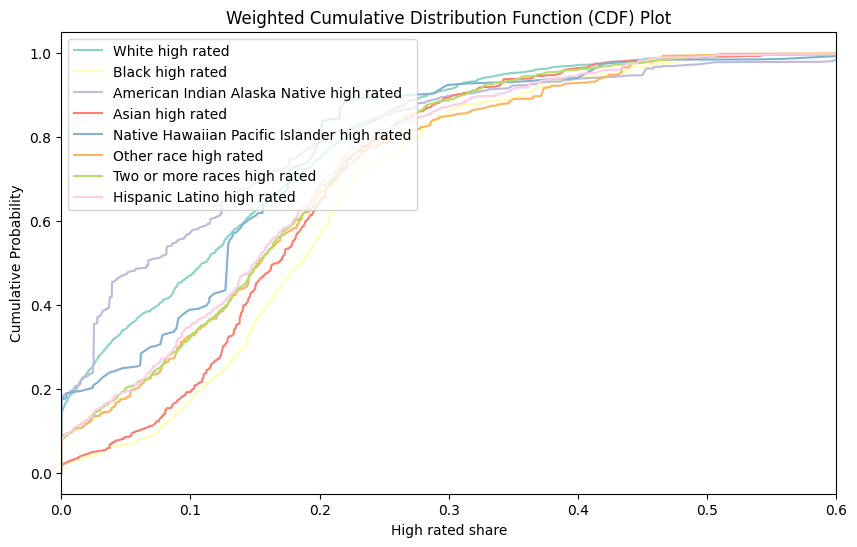

In [23]:
# CDF plot
race_variables2 = [
    'White high rated', 
    'Black high rated', 
    'American Indian Alaska Native high rated', 
    'Asian high rated',
    'Native Hawaiian Pacific Islander high rated',
    'Other race high rated',
    'Two or more races high rated',
    'Hispanic Latino high rated',
]

colors = [
    '#8dd3c7', 
    '#ffffb3', 
    '#bebada', 
    '#fb8072', 
    '#80b1d3', 
    '#fdb462', 
    '#b3de69', 
    '#fccde5']

weight_map2 = {
    'White high rated': 'white',
    'Black high rated': 'black',
    'American Indian Alaska Native high rated': 'am_indian_alaska_native',
    'Asian high rated': 'asian',
    'Native Hawaiian Pacific Islander high rated': 'native_hawaiian_pacific_islander',
    'Other race high rated': 'other_race',
    'Two or more races high rated': 'two_or_more_races',
    'Hispanic Latino high rated': 'hispanic_latino',
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables2, colors):
    # Get the weights for this variable
    weights = data[weight_map2[var]]
    
    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))
    
    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)
    
    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]
    
    ax.plot(values, cumulative, label=var, color=color)

ax.set_title('Weighted Cumulative Distribution Function (CDF) Plot')
ax.set_xlabel('High rated share')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='upper left')

# Set x-axis limit
ax.set_xlim(0, 0.6)

plt.show()

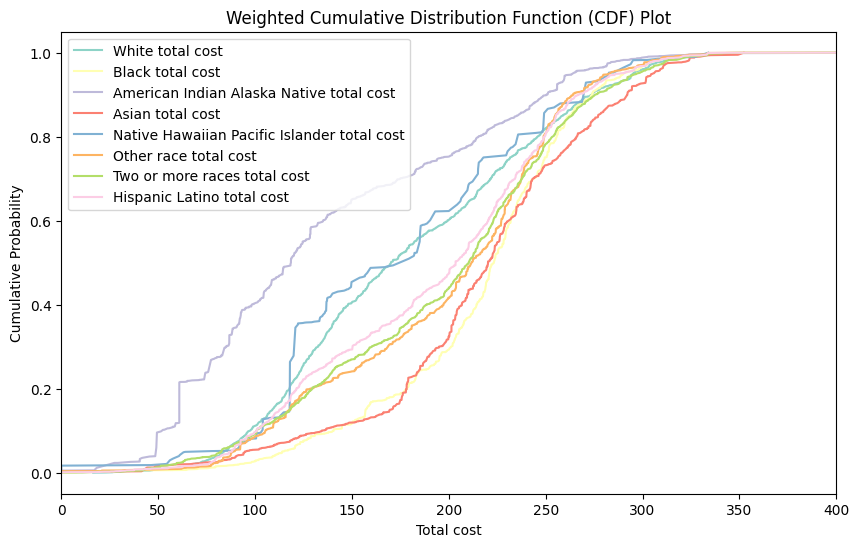

In [24]:
# CDF plot
race_variables3 = [
    'White total cost',
    'Black total cost',
    'American Indian Alaska Native total cost', 
    'Asian total cost',
    'Native Hawaiian Pacific Islander total cost',
    'Other race total cost',
    'Two or more races total cost',
    'Hispanic Latino total cost',
]

colors = [
    '#8dd3c7', 
    '#ffffb3', 
    '#bebada', 
    '#fb8072', 
    '#80b1d3', 
    '#fdb462', 
    '#b3de69', 
    '#fccde5']

weight_map3 = {
    'White total cost': 'white',
    'Black total cost': 'black',
    'American Indian Alaska Native total cost': 'am_indian_alaska_native',
    'Asian total cost': 'asian',
    'Native Hawaiian Pacific Islander total cost': 'native_hawaiian_pacific_islander',
    'Other race total cost': 'other_race',
    'Two or more races total cost': 'two_or_more_races',
    'Hispanic Latino total cost': 'hispanic_latino',
}


fig, ax = plt.subplots(figsize=(10, 6))

for var, color in zip(race_variables3, colors):
    # Get the weights for this variable
    weights = data[weight_map3[var]]
    
    # Sort the values and weights by the values
    values, weights = zip(*sorted(zip(data[var], weights)))
    
    # Calculate the cumulative sum of the weights
    cumulative = np.cumsum(weights)
    
    # Normalize the cumulative sum to create a CDF
    cumulative = cumulative / cumulative[-1]
    
    ax.plot(values, cumulative, label=var, color=color)

ax.set_title('Weighted Cumulative Distribution Function (CDF) Plot')
ax.set_xlabel('Total cost')
ax.set_ylabel('Cumulative Probability')
ax.legend(loc='upper left')

# Set x-axis limit
ax.set_xlim(0, 400)

plt.show()

## Matrix of Differences

In [26]:
# Matrix of differences
# Create an empty dataframe for the matrix
matrix1 = pd.DataFrame(index=race_variables1, columns=race_variables1)

# Calculate the weighted average difference for each pair of variables
for row_var in race_variables1:
    for col_var in race_variables1:
        if row_var != col_var:
            row_weighted_mean = (data[row_var] * data[weight_map1[row_var]]).sum() / data[weight_map1[row_var]].sum()
            col_weighted_mean = (data[col_var] * data[weight_map1[col_var]]).sum() / data[weight_map1[col_var]].sum()
            matrix1.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean


In [27]:
matrix1

,White any,Black any,American Indian Alaska Native any,Asian any,Native Hawaiian Pacific Islander any,Other race any,Two or more races any,Hispanic Latino any
White any,NaN,-0.018817,-0.021563,0.026921,0.020044,-0.022033,-0.016453,-0.015735
Black any,0.018817,NaN,-0.002746,0.045738,0.038861,-0.003216,0.002364,0.003082
American Indian Alaska Native any,0.021563,0.002746,NaN,0.048484,0.041607,-0.00047,0.00511,0.005828
Asian any,-0.026921,-0.045738,-0.048484,NaN,-0.006877,-0.048954,-0.043374,-0.042656
Native Hawaiian Pacific Islander any,-0.020044,-0.038861,-0.041607,0.006877,NaN,-0.042077,-0.036497,-0.035779
Other race any,0.022033,0.003216,0.00047,0.048954,0.042077,NaN,0.00558,0.006298
Two or more races any,0.016453,-0.002364,-0.00511,0.043374,0.036497,-0.00558,NaN,0.000718
Hispanic Latino any,0.015735,-0.003082,-0.005828,0.042656,0.035779,-0.006298,-0.000718,NaN


In [29]:
# Matrix of differences
# Create an empty dataframe for the matrix
matrix2 = pd.DataFrame(index=race_variables2, columns=race_variables2)

# Calculate the weighted average difference for each pair of variables
for row_var in race_variables2:
    for col_var in race_variables2:
        if row_var != col_var:
            row_weighted_mean = (data[row_var] * data[weight_map2[row_var]]).sum() / data[weight_map2[row_var]].sum()
            col_weighted_mean = (data[col_var] * data[weight_map2[col_var]]).sum() / data[weight_map2[col_var]].sum()
            matrix2.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean


In [30]:
matrix2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Native Hawaiian Pacific Islander high rated,Other race high rated,Two or more races high rated,Hispanic Latino high rated
White high rated,NaN,-0.068578,0.007972,-0.050509,-0.012802,-0.041752,-0.032755,-0.033263
Black high rated,0.068578,NaN,0.07655,0.018069,0.055776,0.026825,0.035822,0.035314
American Indian Alaska Native high rated,-0.007972,-0.07655,NaN,-0.058481,-0.020774,-0.049724,-0.040728,-0.041235
Asian high rated,0.050509,-0.018069,0.058481,NaN,0.037707,0.008756,0.017753,0.017245
Native Hawaiian Pacific Islander high rated,0.012802,-0.055776,0.020774,-0.037707,NaN,-0.028951,-0.019954,-0.020462
Other race high rated,0.041752,-0.026825,0.049724,-0.008756,0.028951,NaN,0.008997,0.008489
Two or more races high rated,0.032755,-0.035822,0.040728,-0.017753,0.019954,-0.008997,NaN,-0.000508
Hispanic Latino high rated,0.033263,-0.035314,0.041235,-0.017245,0.020462,-0.008489,0.000508,NaN


In [31]:
# Matrix of differences
# Create an empty dataframe for the matrix
matrix3 = pd.DataFrame(index=race_variables3, columns=race_variables3)

# Calculate the weighted average difference for each pair of variables
for row_var in race_variables3:
    for col_var in race_variables3:
        if row_var != col_var:
            row_weighted_mean = (data[row_var] * data[weight_map3[row_var]]).sum() / data[weight_map3[row_var]].sum()
            col_weighted_mean = (data[col_var] * data[weight_map3[col_var]]).sum() / data[weight_map3[col_var]].sum()
            matrix3.loc[row_var, col_var] = row_weighted_mean - col_weighted_mean


In [32]:
matrix3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Native Hawaiian Pacific Islander total cost,Other race total cost,Two or more races total cost,Hispanic Latino total cost
White total cost,NaN,-35.698944,43.84877,-36.765152,6.122086,-18.283936,-17.504745,-12.005066
Black total cost,35.698944,NaN,79.547714,-1.066208,41.82103,17.415009,18.194199,23.693878
American Indian Alaska Native total cost,-43.84877,-79.547714,NaN,-80.613922,-37.726685,-62.132706,-61.353516,-55.853836
Asian total cost,36.765152,1.066208,80.613922,NaN,42.887238,18.481216,19.260406,24.760086
Native Hawaiian Pacific Islander total cost,-6.122086,-41.82103,37.726685,-42.887238,NaN,-24.406021,-23.626831,-18.127151
Other race total cost,18.283936,-17.415009,62.132706,-18.481216,24.406021,NaN,0.77919,6.27887
Two or more races total cost,17.504745,-18.194199,61.353516,-19.260406,23.626831,-0.77919,NaN,5.49968
Hispanic Latino total cost,12.005066,-23.693878,55.853836,-24.760086,18.127151,-6.27887,-5.49968,NaN


## Matrix of Differences with color

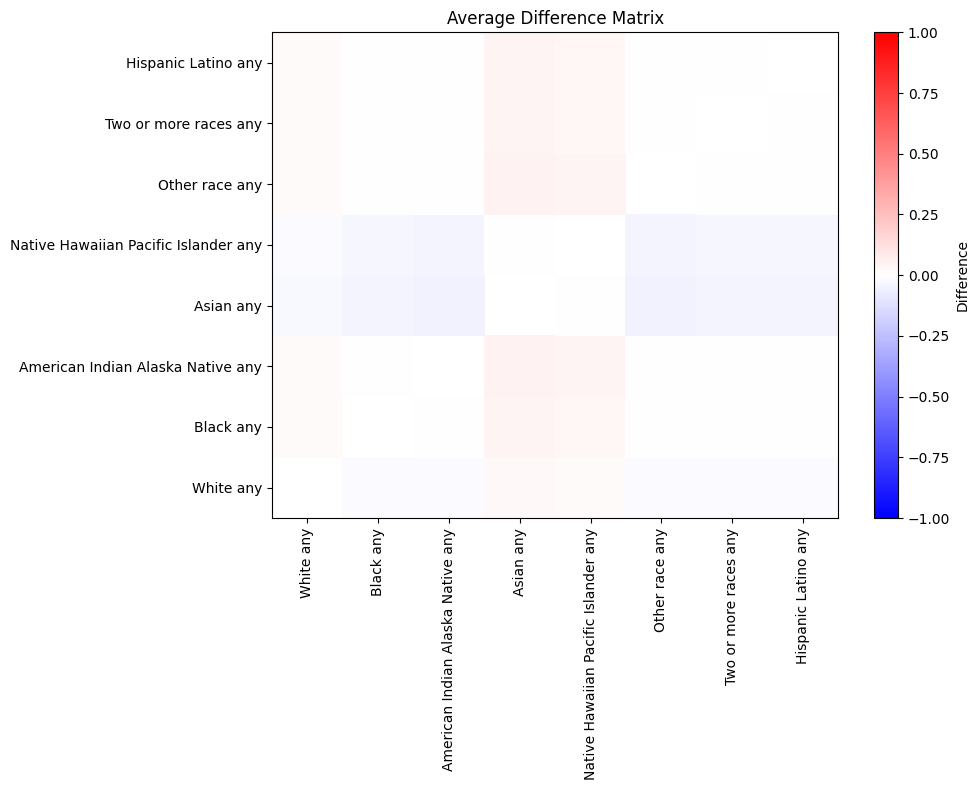

In [33]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix1 = matrix1.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap('bwr')

plt.figure(figsize=(10, 8))
plt.pcolor(matrix1, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label='Difference')
plt.xticks(np.arange(0.5, len(matrix1.columns), 1), matrix1.columns, rotation='vertical', fontsize=10)
plt.yticks(np.arange(0.5, len(matrix1.index), 1), matrix1.index, fontsize=10)
plt.title('Average Difference Matrix')
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

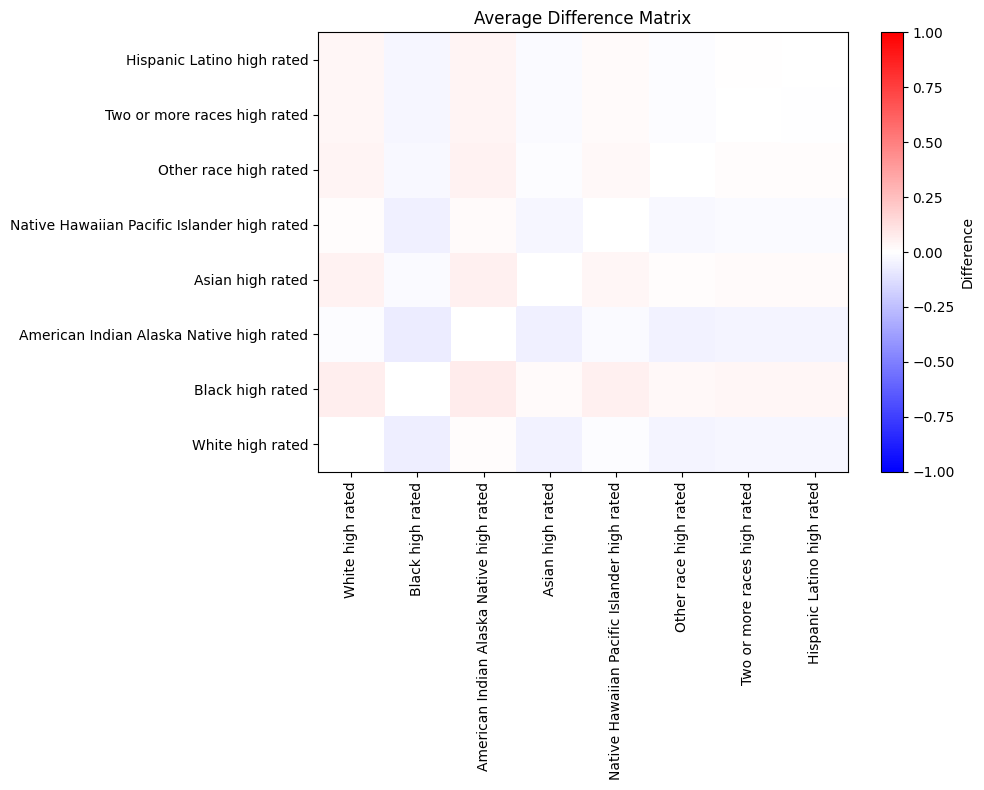

In [34]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix2 = matrix2.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap('bwr')

plt.figure(figsize=(10, 8))
plt.pcolor(matrix2, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label='Difference')
plt.xticks(np.arange(0.5, len(matrix2.columns), 1), matrix2.columns, rotation='vertical', fontsize=10)
plt.yticks(np.arange(0.5, len(matrix2.index), 1), matrix2.index, fontsize=10)
plt.title('Average Difference Matrix')
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

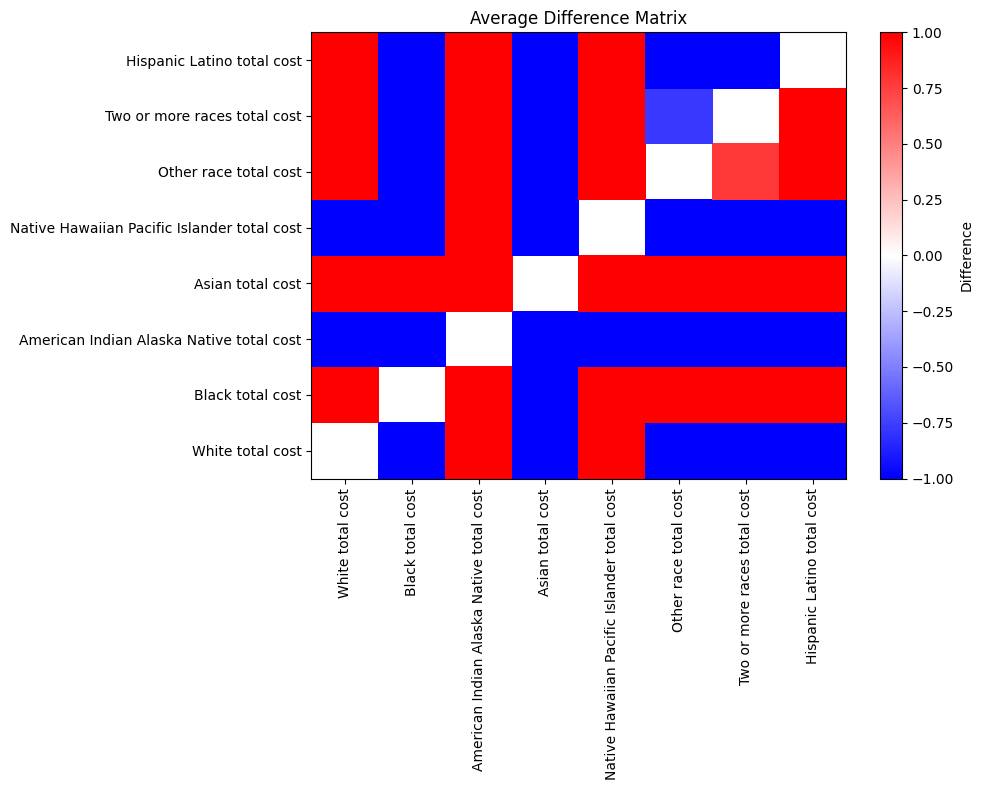

In [35]:
# Matrix of differences

# Color matrix
# Convert the matrix to numeric
matrix3 = matrix3.astype(float)
# Use a diverging colormap (blue for negative, white for zero, red for positive)
colormap = plt.get_cmap('bwr')

plt.figure(figsize=(10, 8))
plt.pcolor(matrix3, cmap=colormap, vmin=-1, vmax=1)
plt.colorbar(label='Difference')
plt.xticks(np.arange(0.5, len(matrix3.columns), 1), matrix3.columns, rotation='vertical', fontsize=10)
plt.yticks(np.arange(0.5, len(matrix3.index), 1), matrix3.index, fontsize=10)
plt.title('Average Difference Matrix')
plt.tight_layout()  # this helps to ensure that labels fit into the figure area
plt.show()

## Regression Tables

In [36]:
def run_regression_analysis(covariates, outcome_variables, data, scalar=1):
    regression_results = {}
    rmse_results = {}

    for outcome in outcome_variables:
        X = sm.add_constant(data[covariates])
        y = data[outcome] * scalar

        model = sm.OLS(y, X)
        result = model.fit()

        rmse = np.sqrt(mean_squared_error(y, result.predict()))

        regression_results[outcome] = result
        rmse_results[outcome] = rmse

    return regression_results, rmse_results

### Any Provider

In [39]:
# Define the covariates
covariates = other_covariates # This is a list of covariates

# Define the outcome variables
outcome_variables = race_variables1 #racial_groups   This is a list of outcome variables

# Define the scalar
scalar = 100  # Replace with your desired scalar

# Call the function to run the regression analysis
regression_results, rmse_results = run_regression_analysis(covariates, outcome_variables, data, scalar)

# Generate the summary table
summary_table = summary_col(
    list(regression_results.values()),
    stars=True,
    float_format='%.3f',
    model_names=outcome_variables,
    info_dict={'N': lambda x: f"{x.nobs:.0f}",
               'R2': lambda x: f"{x.rsquared_adj:.3f}"}
)

# Convert RMSE results to a DataFrame and concatenate with summary table
rmse_df = pd.DataFrame(rmse_results, index=['RMSE'])
summary_df1 = pd.concat([summary_table.tables[0], rmse_df])


In [40]:
summary_df1

,White any,Black any,American Indian Alaska Native any,Asian any,Native Hawaiian Pacific Islander any,Other race any,Two or more races any,Hispanic Latino any
const,51.592*,105.334***,59.124,66.137**,45.120**,67.709*,62.147*,55.472*
,(26.581),(31.435),(36.932),(31.599),(21.509),(36.441),(31.775),(29.400)
Median Household Income,-0.000***,-0.000***,-0.000**,-0.000,-0.000,-0.000***,-0.000***,-0.000**
,(0.000),(0.000),(0.000),(0.000),(0.000),(0.000),(0.000),(0.000)
Gini Index,33.251*,-10.603,19.487,5.487,18.162,24.557,27.246,23.249
,(18.334),(21.682),(25.473),(21.795),(14.836),(25.135),(21.916),(20.278)
Educational Attainment,47.802***,69.150***,5.973,71.476***,-10.575,30.224,44.758***,40.671**
,(14.413),(17.045),(20.026),(17.134),(11.663),(19.760),(17.229),(15.942)
Employment Status,178.940***,141.807**,148.378*,137.384**,-2.193,53.492,191.458***,186.496***
,(55.862),(66.064),(77.617),(66.408),(45.204),(76.585),(66.777),(61.788)


### High Rated

In [41]:
# Define the covariates
covariates = other_covariates # This is a list of covariates

# Define the outcome variables
outcome_variables = race_variables2 #racial_groups   This is a list of outcome variables

# Define the scalar
scalar = 100  # Replace with your desired scalar

# Call the function to run the regression analysis
regression_results, rmse_results = run_regression_analysis(covariates, outcome_variables, data, scalar)

# Generate the summary table
summary_table = summary_col(
    list(regression_results.values()),
    stars=True,
    float_format='%.3f',
    model_names=outcome_variables,
    info_dict={'N': lambda x: f"{x.nobs:.0f}",
               'R2': lambda x: f"{x.rsquared_adj:.3f}"}
)

# Convert RMSE results to a DataFrame and concatenate with summary table
rmse_df = pd.DataFrame(rmse_results, index=['RMSE'])
summary_df2 = pd.concat([summary_table.tables[0], rmse_df])

In [42]:
summary_df2

,White high rated,Black high rated,American Indian Alaska Native high rated,Asian high rated,Native Hawaiian Pacific Islander high rated,Other race high rated,Two or more races high rated,Hispanic Latino high rated
const,-6.252,3.285,-3.226,-3.294,10.683*,1.148,-3.826,-6.199
,(9.375),(9.590),(10.460),(9.926),(5.935),(10.208),(9.789),(9.747)
Median Household Income,0.000***,0.000**,0.000,0.000***,0.000,0.000,0.000***,0.000***
,(0.000),(0.000),(0.000),(0.000),(0.000),(0.000),(0.000),(0.000)
Gini Index,-5.886,-11.139*,-1.914,-4.860,2.212,-12.152*,-8.441,-6.525
,(6.466),(6.614),(7.214),(6.846),(4.094),(7.041),(6.752),(6.723)
Educational Attainment,44.773***,43.026***,23.714***,45.193***,0.147,36.704***,47.223***,43.290***
,(5.083),(5.200),(5.671),(5.382),(3.218),(5.535),(5.308),(5.285)
Employment Status,-50.521**,-66.972***,-51.185**,-57.583***,-11.425,-82.003***,-54.260***,-61.956***
,(19.702),(20.153),(21.982),(20.861),(12.474),(21.454),(20.573),(20.484)


In [43]:
# Define the covariates
covariates = other_covariates # This is a list of covariates

# Define the outcome variables
outcome_variables = race_variables3 #racial_groups   This is a list of outcome variables

# Define the scalar
scalar = 100  # Replace with your desired scalar

# Call the function to run the regression analysis
regression_results, rmse_results = run_regression_analysis(covariates, outcome_variables, data, scalar)

# Generate the summary table
summary_table = summary_col(
    list(regression_results.values()),
    stars=True,
    float_format='%.3f',
    model_names=outcome_variables,
    info_dict={'N': lambda x: f"{x.nobs:.0f}",
               'R2': lambda x: f"{x.rsquared_adj:.3f}"}
)

# Convert RMSE results to a DataFrame and concatenate with summary table
rmse_df = pd.DataFrame(rmse_results, index=['RMSE'])
summary_df3 = pd.concat([summary_table.tables[0], rmse_df])


In [44]:
summary_df3

,White total cost,Black total cost,American Indian Alaska Native total cost,Asian total cost,Native Hawaiian Pacific Islander total cost,Other race total cost,Two or more races total cost,Hispanic Latino total cost
const,4607.443,10739.499*,12533.338,6705.281,12402.621**,12530.323,2798.688,5411.844
,(4491.796),(6292.592),(9062.031),(5836.254),(5166.013),(8482.630),(4940.890),(5333.166)
Median Household Income,0.094***,0.072***,0.013,0.116***,0.000,0.034*,0.096***,0.097***
,(0.010),(0.014),(0.020),(0.013),(0.012),(0.019),(0.011),(0.012)
Gini Index,-11088.116***,-20550.270***,-9730.957,-15870.615***,687.439,-15702.914***,-12409.318***,-12402.092***
,(3098.135),(4340.201),(6250.371),(4025.450),(3563.164),(5850.740),(3407.889),(3678.454)
Educational Attainment,27553.794***,33049.732***,13998.904***,30895.913***,-809.437,20357.304***,27575.345***,27438.856***
,(2435.573),(3412.014),(4913.678),(3164.575),(2801.152),(4599.512),(2679.084),(2891.787)
Employment Status,-50818.784***,-57736.075***,-40822.779**,-52169.492***,-11766.798,-51814.317***,-49400.939***,-49266.724***
,(9439.938),(13224.482),(19044.721),(12265.444),(10856.868),(17827.056),(10383.752),(11208.156)
